# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database. The goals of this analysis include:

1. Evaluating the Sepsis-3 guidelines in MIMIC using the same methodology as in the research paper
2. Evaluating the Sepsis-3 guidelines against ANGUS criteria
3. Assessing if there are interesting subgroup(s) which are missed by the criteria

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

from sklearn.pipeline import Pipeline

# used for train/test splits
from sklearn.cross_validation import train_test_split

# used to impute mean for data
from sklearn.preprocessing import Imputer

# normalize the data
from sklearn import preprocessing

# logistic regression is our model of choice
from sklearn.linear_model import LogisticRegression

# used to create confusion matrix
from sklearn.metrics import confusion_matrix

from sklearn.cross_validation import cross_val_score

# used to calculate AUROC/accuracy
from sklearn import metrics

# for calibration curve of severity scores
from sklearn.calibration import calibration_curve

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

from __future__ import print_function

In [2]:
# create a database connection

# below config used on pc70
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [3]:
# call functions to extract the severity scores
qsofa = su.get_qsofa(con)
sofa = su.get_sofa(con)
oasis = su.get_oasis(con)
lods = su.get_lods(con)
sirs = su.get_sirs(con)
angus = su.get_angus(con)

# Time of suspected infection

Suspected infection is defined as:

* Antibiotics within 72 hours of a culture
* A culture within 24 hours of antibiotics

We can extract antibiotic usage from the, PRESCRIPTIONS, INPUTEVENTS_MV and INPUTEVENTS_CV tables. We can extract time of blood cultures from the MICROBIOLOGYEVENTS table. Detail is given in defining-suspected-infection.ipynb.

In [4]:
ab = su.get_suspected_infection_time(con)

# Other data

This query extracts other data of interest:

* Age
* Gender
* Immunosuppression
* BMI
* Metastatic cancer (Elixhauser comorbidity)
* Diabetes (Elixhauser comorbidity)


In [5]:
misc = su.get_other_data(con)
print('{} ICU stays.'.format(misc.shape[0]))
idx = misc.age > 1
print('{} adult ICU stays.'.format(np.sum(idx)))
demog_col = ['height','weight','bmi']
for c in demog_col:
    print('\t{:2.2f}% have {}.'.format( (np.sum(idx) - misc[c][idx].isnull().sum())*100.0 / np.sum(idx), c ))

61532 ICU stays.
53432 adult ICU stays.
	75.45% have height.
	88.74% have weight.
	69.44% have bmi.


# Cohort

The below code creates our cohort of interest. This cohort is used to apply inclusion criteria by means of an inner join. Inclusion criteria are:

* Adult patient, i.e. age >= 16
* First ICU stay for the patient

In [6]:
cohort = su.get_cohort(con)

# close the database connection as we are finished extracting data
con.close()

# Create dataframe with *all patients*

We can ask some pretty sensible questions of this data.

* What percentage of patients had antibiotics with a culture?
* What percentage of these cultures were positive?

In [7]:
# initialize our dataframe to the cohort
df_all_pt = cohort

# merge in the various severity scores
df_all_pt = df_all_pt.merge(qsofa, how='left', on='icustay_id', suffixes=('','_qsofa'))
df_all_pt = df_all_pt.merge(sofa, how='left', on='icustay_id', suffixes=('','_sofa'))
df_all_pt = df_all_pt.merge(sirs, how='left', on='icustay_id', suffixes=('','_sirs'))
df_all_pt = df_all_pt.merge(ab, how='left', on='icustay_id', suffixes=('','_ab'))
df_all_pt = df_all_pt.merge(misc, how='left', on='icustay_id', suffixes=('','_misc'))
df_all_pt = df_all_pt.merge(oasis, how='left', on='icustay_id', suffixes=('','_oasis'))
df_all_pt = df_all_pt.merge(lods, how='left', on='icustay_id', suffixes=('','_lods'))
df_all_pt = df_all_pt.merge(angus, how='left', on='hadm_id', suffixes=('','_angus'))

# define sepsis-3 as: qSOFA >= 2 and SOFA >= 2
df_all_pt['sepsis3'] = (df_all_pt.qsofa >= 2) & (df_all_pt.sofa >=2)

print('{:5g} adult ICU stays (excluding subsequent ICU stays for the same patient).'.format(
    df_all_pt.shape[0]))

print('{:2.2f}% of patients with antibiotics/culture'.format(
    df_all_pt['suspected_infection_time'].count().astype(float) / df_all_pt.shape[0] * 100))

print('{:2.2f}% of patients with positive cultures'.format(
    df_all_pt['positiveculture'].sum().astype(float) / df_all_pt.shape[0] * 100))

print('{:2.2f}% of patients with antibiotics/culture had a positive culture'.format(
    df_all_pt['positiveculture'].sum().astype(float) / df_all_pt['suspected_infection_time'].count().astype(float) * 100))

38597 adult ICU stays (excluding subsequent ICU stays for the same patient).
20.17% of patients with antibiotics/culture
2.41% of patients with positive cultures
11.93% of patients with antibiotics/culture had a positive culture


# Study population

The Sepsis-3 guidelines exclusively evaluated patients with suspected infection, so we subselect to this population. We then report demographics, etc.

In [8]:
df = df_all_pt.loc[(~df_all_pt['suspected_infection_time'].isnull().values)]
su.print_demographics(df)

print('')
print('{:5g} have qSOFA >= 2 ({:2.2f}%).'.format(
    (df.qsofa.values >= 2).sum(),100.0*(df.qsofa.values >= 2).mean()))

print('{:5g} have SOFA >= 2 ({:2.2f}%).'.format(
    (df.sofa.values >= 2).sum(),100.0*(df.sofa.values >= 2).mean()))

print('{:5g} have Sepsis-3 ({:2.2f}%).'.format(
    (df.sepsis3).sum(),100.0*(df.sepsis3).mean()))

print('{:5g} have SIRS >= 2 ({:2.2f}%).'.format(
    (df.sirs.values >= 2).sum(),100.0*(df.sirs.values >= 2).mean()))

print('{:5g} have LODS >= 2 ({:2.2f}%).'.format(
    (df.lods.values >= 2).sum(),100.0*(df.lods.values >= 2).mean()))

age                 	73.72 +- 51.15
gender              	58.11%
bmi                 	28.96 +- 8.67
hospital_expire_flag	11.23%
thirtyday_expire_flag	13.32%
icu_los             	4.24 +- 5.77
hosp_los            
mech_vent           	29.58%

 5864 have qSOFA >= 2 (75.32%).
 6788 have SOFA >= 2 (87.19%).
 5360 have Sepsis-3 (68.85%).
 7294 have SIRS >= 2 (93.69%).
 7101 have LODS >= 2 (91.21%).


# Study questions

1. How well do the guidelines detect sepsis (Angus criteria) in the antibiotics/culture subset?
2. How well do the guidelines predict mortality (in-hospital) in the antibiotics/culture subset?
3. What factors would improve the sensitivity of the guidelines?
4. What factors would improve the specificity of the guidelines?

## Angus criteria evaluation

In [9]:
# define targets, angus critera
y = df.angus.values == 1

# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat = (df.qsofa.values >= 2) & (df.sofa.values>=2)

print('\n SEPSIS-3 guidelines for Angus criteria sepsis \n')
# generate evaluation metrics
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for Angus criteria sepsis 

Accuracy = 0.519075144509

Confusion matrix
   	yhat=0	yhat=1
y=0	  1670	  2989	NPV=68.87
y=1	   755	  2371	PPV=44.24
   	35.84	75.85	Acc=51.91
   	Spec	Sens


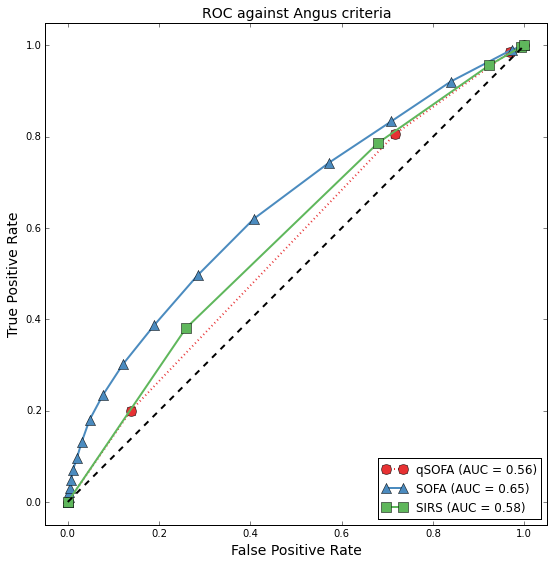

In [10]:
y = df.angus.values == 1

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.figure(figsize=[9,9])
plt.plot(fpr_qsofa, tpr_qsofa, 'o:',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = %0.2f)' % auc_qsofa)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = %0.2f)' % auc_sofa)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = %0.2f)' % auc_sirs)

# add in the combination of SIRS/SOFA
#plt.plot(fpr_s3, tpr_s3, 'd--',
#         color=col[3], linewidth=2, markersize=10,
#         label='SEPSIS-3 (AUC = %0.2f)' % auc_s3)

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC against Angus criteria',fontsize=14)
plt.show()

In [11]:
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [df.qsofa.values >= 2,
            df.sofa.values >= 2,
            df.sepsis3.values,
            df.sirs.values >= 2]
yhat_names = ['qsofa','sofa','seps3','SIRS']

# define "targets", angus critera
y_all = [df.angus.values == 1,
         df.angus.values == 1,
         df.angus.values == 1,
         df.angus.values == 1]


stats_all = su.print_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=['angus criteria sepsis'])

Metric
	angus criteria sepsis

	qsofa	sofa 	seps3	SIRS 
TN   	 1316	  750	 1670	  356
FP   	 3343	 3909	 2989	 4303
FN   	  605	  247	  755	  135
TP   	 2521	 2879	 2371	 2991
Sens 	80.65	92.10	75.85	95.68
Spec 	28.25	16.10	35.84	 7.64
PPV  	42.99	42.41	44.24	41.01
NPV  	68.51	75.23	68.87	72.51
F1   	56.08	58.08	55.88	57.41
DOR  	 1.64	 2.24	 1.75	 1.83


# Hospital mortality evaluation

In [12]:
# define targets, angus critera
y = df.hospital_expire_flag.values == 1

# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat = (df.qsofa.values >= 2) & (df.sofa.values>=2)

print('\n SEPSIS-3 guidelines for hospital mortality \n')
# generate evaluation metrics
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for hospital mortality 

Accuracy = 0.387283236994

Confusion matrix
   	yhat=0	yhat=1
y=0	  2283	  4628	NPV=94.14
y=1	   142	   732	PPV=13.66
   	33.03	83.75	Acc=38.73
   	Spec	Sens


## Reproduce the confusion matrix of AUROCs and p-values

In [13]:
preds_header = ['sirs','sofa','lods','qsofa']
target_header = 'hospital_expire_flag'
su.print_auc_table(df, preds_header, target_header)

     	sirs                	sofa                	lods                	qsofa               	
sirs 	0.609 [0.592, 0.627]	                    	                    	                    	
sofa 	< 0.001               	0.727 [0.706, 0.741]	                    	                    	
lods 	< 0.001               	< 0.001               	0.750 [0.735, 0.767]	                    	
qsofa	0.355               	< 0.001               	< 0.001               	0.598 [0.581, 0.618]	


# Baseline model + scores

The original paper evaluates a *baseline model* with the addition of the various severity scores. 

> To measure predictive validity, a baseline risk model was created for in-hospital mortality based on preinfection criteria using multivariable logistic regression. The baseline model included age (as a fractional polynomial), sex, race/ethnicity (black, white, or other), and the weighted Charlson comorbidity score (as fractional polynomial) as a measure of chronic comorbidities.

This baseline model includes:

* age (fractional polynomial)
* sex
* ethnicity
* Charlson comorbidities (fractional polynomial)

We will reproduce this model, with the following caveats:

1. We will build and evaluate the model on the same dataset, so our estimates are "apparent"
2. We will use Elixhauser comorbidities, not Charlson comorbidities
3. We may not have identical fractional polynomial terms (as we are rebuilding the model on our dataset)



In [14]:
X_header = ['age','elixhauser_hospital','ethnicity','gender','hospital_expire_flag',
       'qsofa','sofa','sepsis3','sirs','lods']

X = df[X_header].values

# add column for gender - yes/no "is male?"
X = np.column_stack([X, np.in1d(X[:,3],('M'))])
idxGender = X.shape[1]-1

# code ethnicity as black/white/other - white is reference
X = np.column_stack([X, np.in1d(X[:,2],('BLACK/AFRICAN AMERICAN','BLACK/CAPE VERDEAN','BLACK/HAITIAN','BLACK/AFRICAN'))])


X = np.column_stack([X, np.in1d(X[:,2],('WHITE','WHITE - RUSSIAN','WHITE - OTHER EUROPEAN','WHITE - BRAZILIAN',
                 'WHITE - EASTERN EUROPEAN'))])

idxEthnicity = X.shape[1]-1
X[:,idxEthnicity] = (X[:,idxEthnicity]==0) & (X[:,idxEthnicity-1]==0) # this is equivalent to "ethnicity != (white or black)"


# subselect our columns of interest, cast to float
idxKeep = [x for x in range(X.shape[1]) if x not in (2, 3)]
X = X[:, idxKeep].astype(float)
X_header = [xval for x, xval in enumerate(X_header) if x in idxKeep]
X_header.extend(['is_male', 'race_black', 'race_other'])

# remove those with NaN outcome
idxBad = np.isnan(X[:,0])
X = X[~idxBad,:]
print('Removed {} patients with no outcome ({:2.2f}%).'.format(np.sum(idxBad), np.mean(idxBad)*100.0))

df_mdl = pd.DataFrame.from_records(X, columns=X_header)
df_mdl.head()

Removed 0 patients with no outcome (0.00%).


,age,elixhauser_hospital,hospital_expire_flag,qsofa,sofa,sepsis3,sirs,lods,is_male,race_black,race_other
0,86.4824,8,0,1,4,0,1,3,1,1,0
1,60.7953,-10,0,2,5,1,3,5,1,0,0
2,59.1663,-4,0,2,5,1,3,4,0,0,0
3,45.2303,12,0,2,4,1,4,3,1,0,0
4,83.9635,-4,0,1,6,0,3,5,1,0,0


In [15]:
model = logit(formula="hospital_expire_flag ~ age + elixhauser_hospital + race_black + race_other + is_male", data=df_mdl).fit()
print('Baseline model AUROC: {:0.3f}'.format(metrics.roc_auc_score(df_mdl["hospital_expire_flag"],model.predict())))
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.321218
         Iterations 7
Baseline model AUROC: 0.723
                            Logit Regression Results                            
Dep. Variable:     hospital_expire_flag   No. Observations:                 7785
Model:                            Logit   Df Residuals:                     7779
Method:                             MLE   Df Model:                            5
Date:                  Tue, 21 Jun 2016   Pseudo R-squ.:                 0.08545
Time:                          10:41:35   Log-Likelihood:                -2500.7
converged:                         True   LL-Null:                       -2734.3
                                          LLR p-value:                 9.228e-99
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -2.6701      0.086    -

In [16]:
# Add in the various components - print AUROCs
model = logit(formula="hospital_expire_flag ~ age + elixhauser_hospital" +
              " + race_black + race_other + is_male", data=df_mdl).fit(disp=0)
print('{:10s} {:0.3f}'.format('Baseline', metrics.roc_auc_score(df_mdl["hospital_expire_flag"],model.predict())))
for score_added in ['sirs','qsofa','sofa','lods']:
    model = logit(formula="hospital_expire_flag ~ age + elixhauser_hospital + race_black + race_other + is_male + " + score_added,
                  data=df_mdl).fit(disp=0)
    print('{:10s} {:0.3f}'.format(score_added, metrics.roc_auc_score(df_mdl["hospital_expire_flag"],model.predict())))

Baseline   0.723
sirs       0.741
qsofa      0.737
sofa       0.791
lods       0.802


In [17]:
# reproduce the confusion matrix plot
su.print_auc_table(df, preds_header, target_header)
su.print_auc_table_baseline(df_mdl, preds_header, target_header)

     	sirs                	sofa                	lods                	qsofa               	
sirs 	0.609 [0.592, 0.621]	                    	                    	                    	
sofa 	< 0.001               	0.727 [0.712, 0.743]	                    	                    	
lods 	< 0.001               	< 0.001               	0.750 [0.735, 0.764]	                    	
qsofa	0.355               	< 0.001               	< 0.001               	0.598 [0.583, 0.618]	
     	sirs                	sofa                	lods                	qsofa               	
sirs 	0.741 [0.727, 0.755]	                    	                    	                    	
sofa 	< 0.001               	0.791 [0.779, 0.803]	                    	                    	
lods 	< 0.001               	0.022               	0.802 [0.788, 0.812]	                    	
qsofa	0.481               	< 0.001               	< 0.001               	0.737 [0.722, 0.748]	


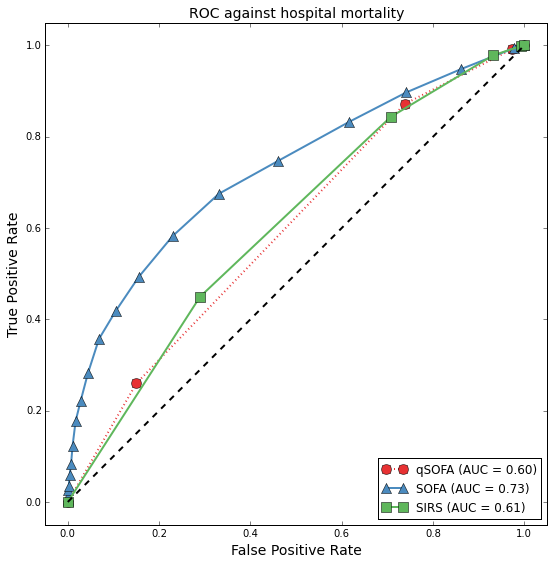

In [18]:
# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.figure(figsize=[9,9])
plt.plot(fpr_qsofa, tpr_qsofa, 'o:',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = %0.2f)' % auc_qsofa)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = %0.2f)' % auc_sofa)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = %0.2f)' % auc_sirs)

# add in the combination of SIRS/SOFA
#plt.plot(fpr_s3, tpr_s3, 'd--',
#         color=col[3], linewidth=2, markersize=10,
#         label='SEPSIS-3 (AUC = %0.2f)' % auc_s3)

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC against hospital mortality',fontsize=14)
plt.show()

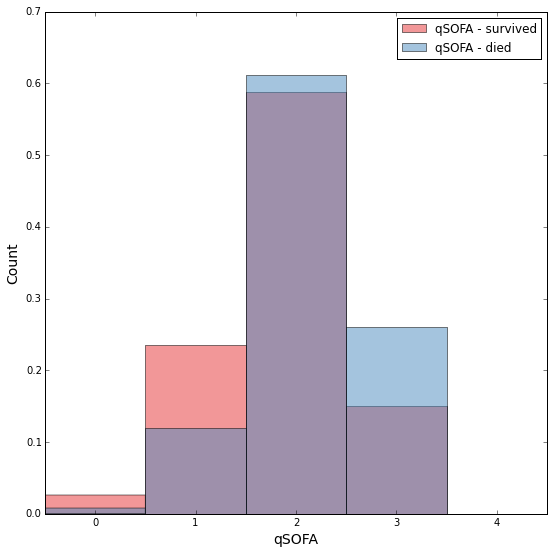

In [19]:
# histogram of the qSOFA values in septic/non-septic population
y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

# plot the data
plt.figure(figsize=[9,9])
plt.hist(qsofa_alive, bins=xi, normed=True, color=col[0], alpha=0.5,
         label='qSOFA - survived')
plt.hist(qsofa_dead, bins=xi, normed=True, color=col[1], alpha=0.5,
         label='qSOFA - died')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Count',fontsize=14)
#plt.title('ROC against hospital mortality',fontsize=14)
plt.show()


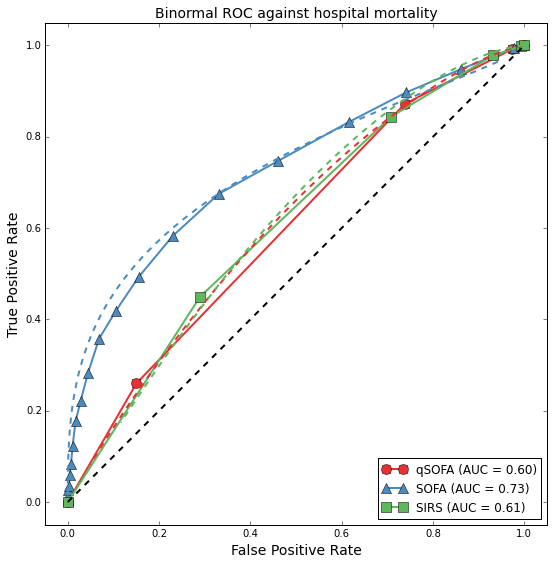

In [27]:
y = df.hospital_expire_flag.values == 1
plt.figure(figsize=[9,9])

# === NORMAL EMPIRICALLY DERIVED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, 'o-',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = %0.2f)' % auc_qsofa)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = %0.2f)' % auc_sofa)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = %0.2f)' % auc_sirs)


# === BINORMAL ESTIMATED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = ru.binormal_roc(df.qsofa.values[y], df.qsofa.values[~y])
auc_qsofa = ru.binormal_auroc(df.qsofa.values[y], df.qsofa.values[~y])

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = ru.binormal_roc(df.sofa.values[y], df.sofa.values[~y])
auc_sofa = ru.binormal_auroc(df.sofa.values[y], df.sofa.values[~y])

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = ru.binormal_roc(df.sirs.values[y], df.sirs.values[~y])
auc_sirs = ru.binormal_auroc(df.sirs.values[y], df.sirs.values[~y])

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, '--',
         color=col[0], linewidth=2, markersize=10)
plt.plot(fpr_sofa, tpr_sofa, '--',
         color=col[1], linewidth=2, markersize=10)
plt.plot(fpr_sirs, tpr_sirs, '--',
         color=col[2], linewidth=2, markersize=10)

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Binormal ROC against hospital mortality',fontsize=14)
plt.show()

In [ ]:
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [df.qsofa.values >= 2,
            df.sofa.values >= 2,
            df.sepsis3.values,
            df.sirs.values >= 2]
yhat_names = ['qsofa','sofa','seps3','SIRS']

# define "targets", angus critera
y_all = [df.hospital_expire_flag.values == 1,
         df.hospital_expire_flag.values == 1,
         df.hospital_expire_flag.values == 1,
         df.hospital_expire_flag.values == 1]


stats_all = su.print_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=['in-hospital mortality'])